In [5]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from dataloaders import get_pkmn_dataloader
import torch.nn.functional as F
import numpy as np

# library to get dataloader
from dataloaders import get_pkmn_dataloader

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout

# util methods
from utils import get_noise

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))

Using device: cpu


In [6]:
print(torch.__version__)

channel_means = [0.5, 0.5, 0.5]
channel_stds = [0.5, 0.5, 0.5]

denorm_means = [-1.0 * mean/std for mean,std in zip(channel_means, channel_stds)]

denorm_stds = [1.0 / std for std in channel_stds]

norm_transform = transforms.Normalize(mean=channel_means, std = channel_stds)
denorm_transform = transforms.Normalize(mean = denorm_means, std =denorm_stds)



# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    #image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    if denorm_transform is not None:
      image_tensor = denorm_transform(image_tensor)
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

1.10.2


In [ ]:
# Test that the data loading library works

dataloader_name = "shiny_64_dim_normalize_and_random_flip_concat_from_data"
batch_size = 4

# just for easy local testing
my_dataloader, denorm_func = get_pkmn_dataloader(dataloader_name, batch_size) 


data_iter = iter(my_dataloader)
images, labels = next(data_iter)

# shape = (bs, num_channels, width, height)
print(images.shape)
print(labels)
print("Dataset size is: {}".format(len(my_dataloader)))
show_tensor_images(images, num_images = batch_size, size = (3,64,64), denorm_transform = None)

In [ ]:
show_tensor_images(images, num_images = batch_size, size = (3,64,64), denorm_transform = denorm_func)

In [ ]:
# Test loading the data
# See example from: https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2


png_directory = "./pokemon_data/gen_5/main-sprites/black-white/"
jpg_directory = "./pokemon_images_all_size=64_shiny=True/" 

# useful transformations include:

# Normalize - we want our data to be mean 0 and std 1 
# CenterCrop - seems like there's a lot of whitespace in the border, can probably remove some of it.

# We should also include random transformations in order to increase the diversity of our training data



normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1]

dataset_transforms = transforms.Compose([
  #transforms.CenterCrop(84),
  transforms.ToTensor(),
  norm_transform
])



# Note that ImageFolder expects a subdirectory for each class label
# If we're doing pokemon stuff, I think it makes sense to pre-process the data by pokemon type first and then save it
# into the appropriate folder (but we can do that later!)


# we can also create a custom dataset but that might be overkill
# one issue with the folder thing is making sure the types are consistent (ie. label 0 = fire type etc.) across
# training runs and all that


class_to_idx = {
  1 : "fire"
}

test_batch_size = 4

pkmn_data = datasets.ImageFolder(root = jpg_directory,transform = dataset_transforms)
pkmn_dataloader = torch.utils.data.DataLoader(dataset=pkmn_data, 
                                              batch_size=test_batch_size, shuffle=True, num_workers=1)

print("Dataset total size is: {}".format(len(pkmn_dataloader) * test_batch_size))

In [ ]:
data_iter = iter(pkmn_dataloader)
images, labels = next(data_iter)

# shape = (bs, num_channels, width, height)
print(images.shape)
print(labels)


# print(images[0][0].shape)

In [ ]:
# looks like there's a lot of whitespace when loading the images...

show_tensor_images(images, num_images = 2, size = (3,64,64), denorm_transform = None)

In [ ]:
# checking that denormalization works to recover the original image
show_tensor_images(images, num_images = 2, size = (3,64,64), denorm_transform = denorm_transform)

In [ ]:
# Example of getting the mean/std stats for each channel in the dataset
# just get the mean and std given a dataset / dataloader basically...

test_batch_size = 4

jpg_directory = "./pokemon_images_all_size=64_shiny=True/"
pkmn_data = datasets.ImageFolder(root = jpg_directory,transform = transforms.ToTensor())
pkmn_dataloader = torch.utils.data.DataLoader(dataset=pkmn_data, 
                                              batch_size=test_batch_size, shuffle=True, num_workers=1)

dataloader_name = "shiny_64_dim_blackbg_normalize_and_random_transform_from_data"
batch_size = 4


running_mean_sum = torch.zeros(3)
running_std_sum = torch.zeros(3)

for images, _ in tqdm(pkmn_dataloader):
  
  flattened = images.view(test_batch_size, 3, -1)
  
  mean_per_channel_in_batch = torch.sum(flattened, dim = -1)
  mean_per_channel = torch.sum(mean_per_channel_in_batch, dim = 0)

  std_per_channel_in_batch = torch.std(flattened, dim = -1)
  std_per_channel = torch.sum(std_per_channel_in_batch, dim = 0)
  
  running_mean_sum += mean_per_channel
  running_std_sum += std_per_channel
  
  batches += 1

final_mean_per_channel = running_mean_sum / (batches * test_batch_size * 64 * 64)
final_std_per_channel = running_std_sum / (batches * test_batch_size)


print("[Dataloader Stats] Final mean per channel is: {}, final std per channel is: {}".format(final_mean_per_channel, final_std_per_channel))

In [41]:
# Example of loading data from classification of types (with different labels)
# And a quick explorer to only load images of a certain type

# todo: check if this is consistent ?

"""
conditional_dir = "./pokemon_images_by_type_all_size=64_shiny=False/"

dataset_transforms = transforms.Compose([
  #transforms.CenterCrop(84),
  transforms.ToTensor()
])


conditional_pkmn_data = datasets.ImageFolder(root = conditional_dir,transform = dataset_transforms)
conditional_pkmn_dataloader = torch.utils.data.DataLoader(dataset=conditional_pkmn_data, 
                                              batch_size=512, shuffle=True, num_workers=1)
"""

# conditional_64_dim_no_shiny_with_flip_and_rotate_and_custom_norm
# conditional_64_dim_no_shiny_with_flip_standard_norm
# conditional_64_dim_no_shiny_with_flip_custom_norm
cond_dataloader_name = 'conditional_64_no_shiny_mainclass_flip_rotate_standard_norm'
batch_size = 128
conditional_pkmn_dataloader, denorm_transform = get_pkmn_dataloader(cond_dataloader_name, batch_size) 

print(conditional_pkmn_dataloader)

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


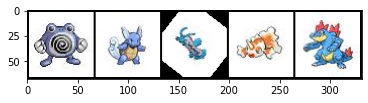

In [52]:
conditional_iter = iter(conditional_pkmn_dataloader)
cond_images, cond_labels = next(conditional_iter)
cond_images = cond_images.numpy()
cond_labels = cond_labels.numpy()

# Type Groups

# (Water, Ice)
# (Ground, ROck)



# map from idx to type name
# pytorch automatically sorts all the files by name
type_names_full = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy','Fighting','Fire','Flying','Ghost',
              'Grass','Ground','Ice','Normal','Poison','Psychic','Rock','Steel','Water']

type_names = ['Bug', 'Dragon', 'Electric', 'Fighting',
              'Fire','Ghost','Grass','Normal','Poison',
              'Psychic','Rock','Steel','Water']

# Possible Groups
# (Water, Ice)
# (Rock, Ground)
# (Bug, Flying)
# (Fairy, Psychic)
# (Ghost, Dark)

assert len(type_names) == 13

idx2type_dict = dict()

for i in range(0, len(type_names)):
  idx2type_dict[i] = type_names[i]
  
# small utility method to get a list of some pokemon of a given type from the batch sample
target_type_1 = 'Water'
target_type_2 = "Water"

target_idx_1 = type_names.index(target_type_1)
target_idx_2 = type_names.index(target_type_2)

idx_mask = np.logical_or(cond_labels == target_idx_1, cond_labels == target_idx_2)#(cond_labels == target_idx & cond_labels == target_idx + 1)

target_images = cond_images[idx_mask]

num_target_images = min(target_images.shape[0], 5)


# looks like there's a lot of whitespace when loading the images btw

show_tensor_images(torch.from_numpy(target_images), num_images = num_target_images, size = (3,64,64), denorm_transform = denorm_transform)

In [32]:
# Playing around with conditional generation signature

# Create the dataloader, based on the appropriate batch size. 

show_preview = True
test_bs = 16
dataloader_name = "shiny_64_dim_normalize_and_random_transform"
pkmn_dataloader, denorm_transform = get_pkmn_dataloader(dataloader_name, test_bs)


# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("Dataset total size is: {}".format(len(pkmn_dataloader) * test_bs))

Dataset total size is: 4944


[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


In [ ]:
# Signature for the conditonal generator

z_dim = 16

sample_noise = get_noise(test_bs, z_dim)

print(sample_noise.shape)
print("True labels are: {}".format(test_labels))

labels_reshaped = test_labels.view(test_bs, 1)

# now this is shape [batch, z_dim + 1]
noise_and_label_concat = torch.cat((sample_noise, labels_reshaped), dim = 1)

print(noise_and_label_concat.shape)
# noise and label concat is the input to our generator

# what do we do inside the generator ?

restored_noise = noise_and_label_concat[:,0:-1]
restored_labels = noise_and_label_concat[:,-1]

print(restored_noise.shape)
print(restored_labels.shape)

# want to one-hot encode each label

onehot_labels = F.one_hot(restored_labels.long(), num_classes = 18)

print(onehot_labels.shape) # shape [bs, num_classes]

final_input = torch.cat([restored_noise, onehot_labels], dim = 1)

print("Shape of final input is: {}".format(final_input.shape)) # shape = [bs, z_dim + num_classes]
 


In [ ]:
# What about the conditional discriminator ?
# The forward function can take multiple inputs ? 
# So the signature is just (images, true_labels)

discriminator_input = torch.rand((test_bs, 3, 64, 64))
embed = torch.nn.Embedding(num_embeddings = 18, embedding_dim = 16)

# How do we get an encoding of the class ?

class_embed = embed(test_labels)

# shape [bs, embed_size]
print(class_embed.shape)

class_embed_tiled = class_embed.tile((4,64)).view(test_bs, 1, 64, 64)

print(discriminator_input.shape)
print(class_embed_tiled.shape)


final_input = torch.cat((discriminator_input, class_embed_tiled), dim=1)

print(final_input.shape)



In [ ]:
# What about the loss function/targets ? I dont think that changes..


# What about the training process? I think we have to generate fake classes according to a distribution? Maybe it
# can be uniform though...actually they just use the true labels.